# in this notebook let's do some basic EDA, to explore the trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%run /Users/yaoyao/Documents/datascience/toolbox/toolbox1_dataview.ipynb
%matplotlib inline

## read in data

In [2]:
with open('train.csv') as f:
    raw_train = pd.read_csv(f)
with open('test.csv') as f:
    raw_test = pd.read_csv(f)
with open('train_labels.csv') as f:
    raw_train_labels = pd.read_csv(f)

## clean the train data
- as instructed, train data contains istallation_id which never take assessments, while test data has at least one
- so we need to remove these data from the train

In [67]:
def cleantrain(raw_train):
    # 1.get installation_id with only one game session
    # all records doing assessments
    astrain = raw_train[raw_train['type'] == 'Assessment'].loc[:,['installation_id','game_session']]
    # all insid ever done assessment
    inid2keep = astrain.groupby('installation_id').count().index
    train = raw_train[raw_train['installation_id'].isin(inid2keep)]
    
    # 2. convert timestamp
    # The T is just a literal to separate the date from the time, 
    # and the Z means "zero hour offset" also known as "Zulu time" (UTC).
    ts = pd.to_datetime(train.iloc[:,2])
    train.insert(0,'ts',ts)
    train.insert(1,'hour',ts.dt.hour)
    train.insert(2,'dayofweek',ts.dt.dayofweek)
    return train

In [68]:
train = cleantrain(raw_train)
# reduce records from 124e6 to 91 e6
# now the train and test should be ~same distribution

## varify the distribution of train and test

In [22]:
def plot_dis(train,raw_test):
    plottest = raw_test.loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    plottrain = train.loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    plottest2 = raw_test[raw_test['type'] == 'Assessment'].loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    plottrain2 = train[train['type'] == 'Assessment'].loc[:,['installation_id','game_session']].groupby(['installation_id']).count()
    figs, axes = plt.subplots(1,2,figsize=(10,4))
    sns.distplot(plottest.game_session,label='test',ax = axes[0])
    sns.distplot(plottrain.game_session,label='train',ax = axes[0])
    axes[0].legend(ncol=2, loc="lower right", frameon=True)
    axes[0].set(xlabel="# of game_sessions",ylabel="distribution",title = 'distribution of # of game_sessions per insid')
    
    sns.distplot(plottest2.game_session,label='test',ax = axes[1])
    sns.distplot(plottrain2.game_session,label='train',ax = axes[1])
    axes[1].legend(ncol=2, loc="lower right", frameon=True)
    axes[1].set(xlabel="# of asses_sessions",ylabel="distribution",title = 'distribution of # of asses_sessions per insid')

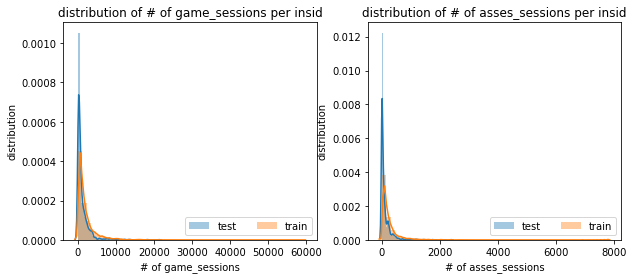

In [23]:
plot_dis(train,raw_test)
# the distribution is almost the same :) good

## now let's explore the time features

In [92]:
def plot_timestamp_train(train):
    figs,axes = plt.subplots(4,1,figsize=(20,10))
    #1, # of game sessions per hour
    pdata = train.loc[:,['game_session','hour']].groupby('hour').count().reset_index()
    sns.barplot(x='hour',y='game_session',data=pdata,ax=axes[0])
    axes[0].set(title='# of all sessions per hour',xlabel='hour',ylabel='counts')
    # # of assessment sessions per hour
    pdata = train[train['type']=='Assessment'].loc[:,['game_session','hour']].groupby('hour').count().reset_index()
    sns.barplot(x='hour',y='game_session',data=pdata,ax=axes[1])
    axes[1].set(title='# of assess sessions per hour',xlabel='hour',ylabel='counts')
    # # of games per hour
    pdata = train[train['type']=='Game'].loc[:,['game_session','hour']].groupby('hour').count().reset_index()
    sns.barplot(x='hour',y='game_session',data=pdata,ax=axes[2])
    axes[2].set(title='# of Game sessions per hour',xlabel='hour',ylabel='counts')
    # of all sessions per day of week
    pdata = train.loc[:,['game_session','dayofweek']].groupby('dayofweek').count().reset_index()
    sns.barplot(x='dayofweek',y='game_session',data=pdata,ax=axes[3])
    axes[3].set(title='# of all sessions per dayofweek',xlabel='dayofweek',ylabel='counts')
    
    
    

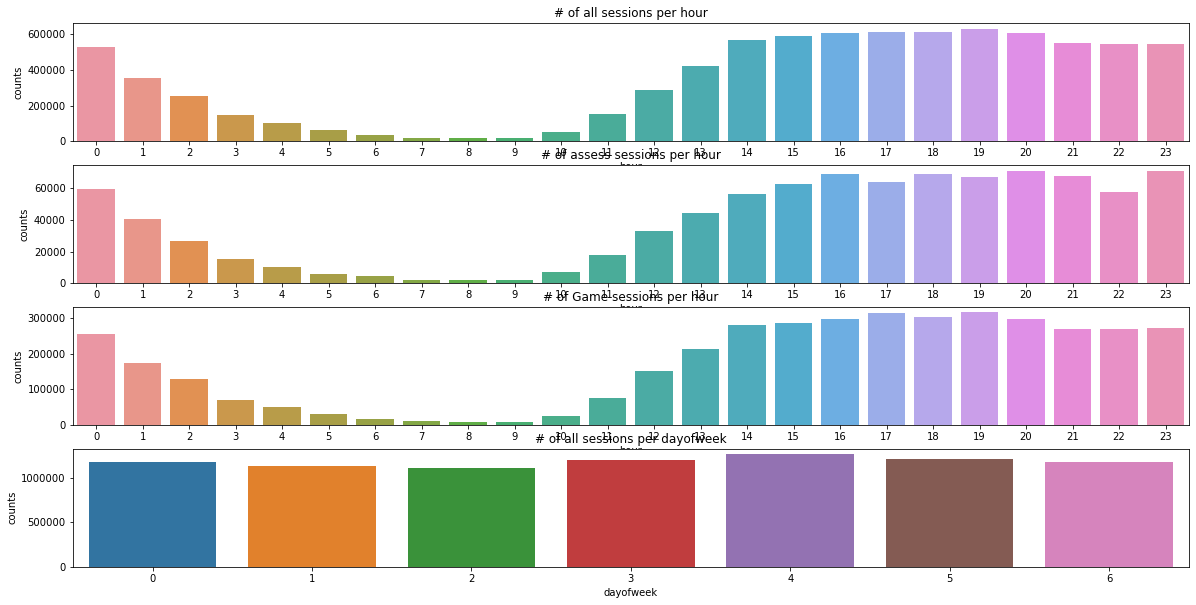

In [93]:
plot_timestamp_train(train)

In [71]:
train.loc[:,['game_session','hour']].groupby('hour').count().reset_index()

,hour,game_session
0,0,525243
1,1,356248
2,2,251838
3,3,145352
4,4,103889
5,5,62361
6,6,37805
7,7,20974
8,8,17836
9,9,18326


In [88]:
train.head()

,ts,hour,dayofweek,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,2019-08-06 04:57:18.904000+00:00,4,1,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,2019-08-06 04:57:45.301000+00:00,4,1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,2019-08-06 04:58:14.538000+00:00,4,1,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,2019-08-06 04:58:14.615000+00:00,4,1,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,2019-08-06 04:58:16.680000+00:00,4,1,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
